# Einstein-Bianchi equations

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.1))

importing NGSolve-6.2.2204


In [2]:
n = specialcf.normal(3)

def CurlTHcc2Hcd(E,dH):
    return InnerProduct(curl(E).trans, dH)*dx \
       +InnerProduct(Cross(E*n, n), dH*n)*dx(element_boundary= True)

def DivHcdHd(H,dv):
    return div(H)*dv*dx - H*n*n * dv*n * dx(element_boundary= True)

In [3]:
order = 1
fescc = HCurlCurl(mesh, order=order)

fescd = HCurlDiv(mesh, order=order)
fesd = HDiv(mesh, order=order)
fescd_d = fescd*fesd

E, dE = fescc.TnT()
(H,v), (dH, dv) = fescd_d.TnT()

In [34]:
massE = BilinearForm(InnerProduct(E,dE)*dx).Assemble()

massH = BilinearForm(fescd_d)
massH += InnerProduct(H,dH)*dx + DivHcdHd(H,dv) + DivHcdHd(dH,v) - 1e-3*v*dv*dx - div(v)*div(dv)*dx
massH.Assemble()

bfcurlT = BilinearForm(CurlTHcc2Hcd(E, fescd.TestFunction()), geom_free= True).Assemble()

In [35]:
massEinv = massE.mat.Inverse(inverse="pardiso")
massHinv = massH.mat.Inverse(inverse="pardiso")
resH = fescd_d.restrictions[0]
massHinv = resH@massHinv@resH.T

In [36]:
gfE = GridFunction(fescc)
gfH = GridFunction(fescd)

In [37]:
gfE.components

()

In [38]:
# initial conditions ....
gfH.vec[:] = 0.0
gfE.vec[:] = 0.0

peak = exp(-((x-0.5)**2+(y-0.5)**2+(z-0.5)**2)/ 0.2**2 )
gfE.Set ( ((0, 0,peak), (0,0,0), (peak,0,0) ))
gfH.Set(  ((peak, 0,0), (0,0,0), (0,0,-peak)))

In [39]:
def Transpose(gfu):
    return CF((   gfu[0,0],gfu[1,0],gfu[2,0],
                  gfu[0,1],gfu[1,1],gfu[2,1],
                  gfu[0,2],gfu[1,2],gfu[2,2]), dims = (3,3))

def Trace(gfu): return CF((gfu[0,0]+gfu[1,1]+gfu[2,2]))

In [40]:
t = 0
tend = 1
dt = 1e-2

traceE = []
symH = []
divH = []
traceH = []

scene = Draw(Norm(gfH), mesh, clipping ={"x": 0, "y":0 , "z": -1})
#gfE.vec.data = massEinv * gfE.vec
SetNumThreads(8)
with TaskManager():
    while t < tend:
        gfE.vec.data += -dt * massEinv@bfcurlT.mat.T * gfH.vec
        gfH.vec.data += dt * massHinv@bfcurlT.mat * gfE.vec
        scene.Redraw()
        t += dt
        traceE.append(Integrate(Norm(Trace(gfE)), mesh) )    
        symH.append(Integrate(Norm(Transpose(gfH)- gfH), mesh) )
        traceH.append(Integrate(Norm(Trace(gfH)), mesh))


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

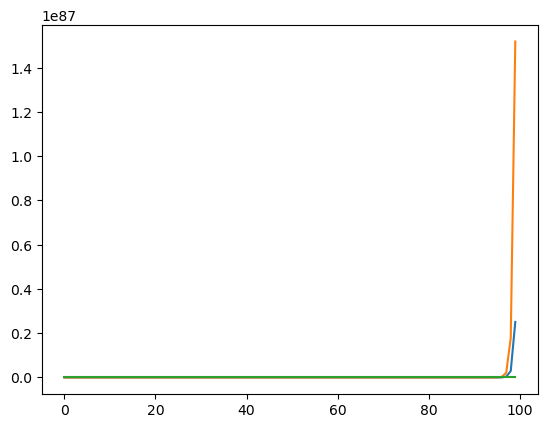

In [41]:
import matplotlib.pyplot as plt

plt.plot(traceE)
plt.plot(symH)
plt.plot(traceH)

In [32]:
print(Integrate(Norm(gfE), mesh))

0.4857012961412337


In [33]:
help(SetNumThreads)

Help on built-in function SetNumThreads in module pyngcore.pyngcore:

SetNumThreads(...) method of builtins.PyCapsule instance
    SetNumThreads(threads: int) -> None
    
    
    Set number of threads
    
    Parameters:
    
    threads : int
      input number of threads

